In [12]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:

from config import DUCKDB_PATH

# global duckdb connection
con = duckdb.connect(DUCKDB_PATH)
AGG_COLUMNS = [
    'eth_type',
    'ip_src',
    'ip_dst',
]

# print number of attacks and non-attacks
sql = """
    SELECT * FROM merged_aggregated
"""
full_data = con.execute(sql).df()

full_data
con.close()

In [3]:

# print number of attacks and non-attacks
con = duckdb.connect(DUCKDB_PATH)
sql = """
    SELECT COUNT(*) AS num_attacks, attack_type
    FROM merged_aggregated
    GROUP BY attack_type
"""

result = con.execute(sql).df()

result
con.close()

## Boxplot Analysis

Text(0.5, 0.98, 'Feature distribution for IP addresses with and without attacks')

<Figure size 500x300 with 0 Axes>

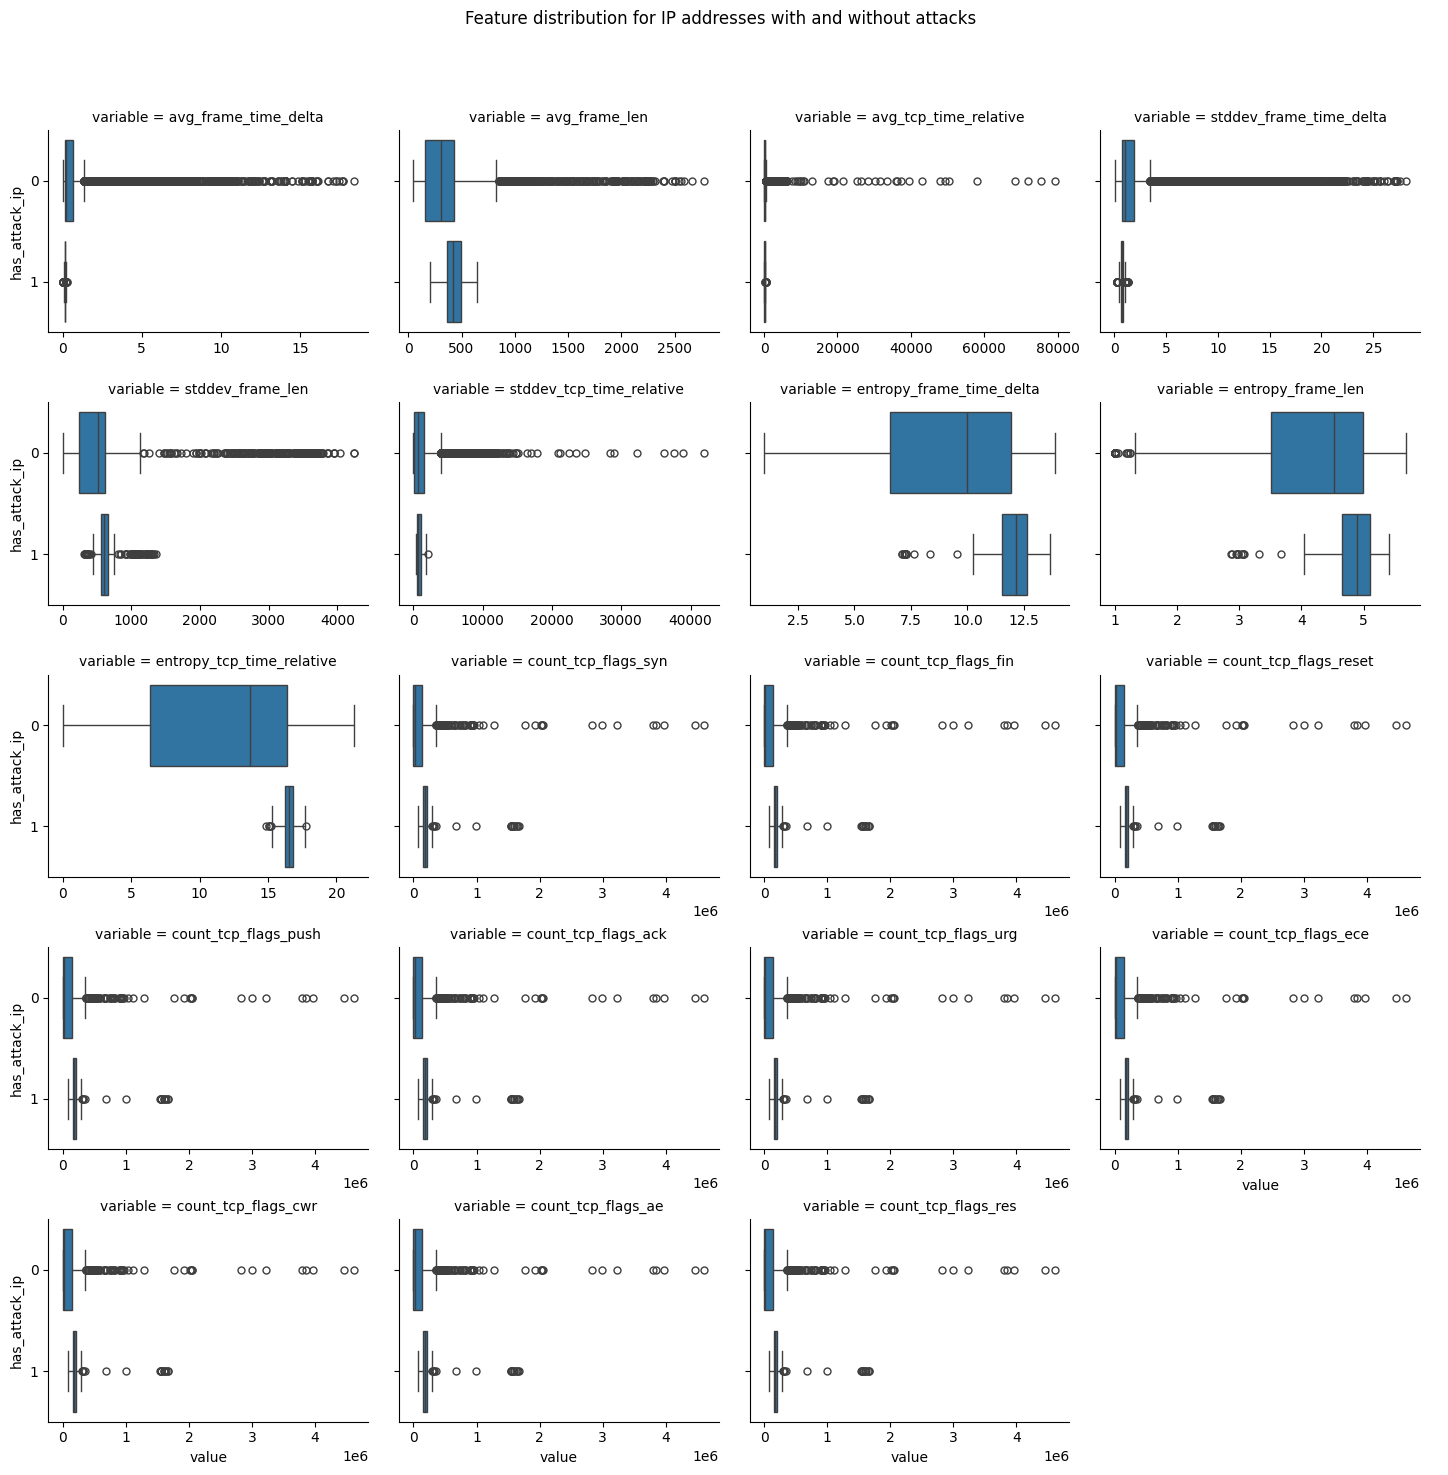

In [28]:
# look at some different features
from config import ATTACK_TYPE_MAPPING


plt.figure(figsize=(5, 3))
# pivot columns to longer format
bots_data_melt = full_data.melt(id_vars=['date_minutes', 'attack_type', 'is_attack', 'has_attack_ip'], value_vars=[
    'avg_frame_time_delta',
    'avg_frame_len',
    'avg_tcp_time_relative',
    
    'stddev_frame_time_delta',
    'stddev_frame_len',
    'stddev_tcp_time_relative',
    
    'entropy_frame_time_delta',
    'entropy_frame_len',
    'entropy_tcp_time_relative',
    
    'count_tcp_flags_syn',
    'count_tcp_flags_fin',
    'count_tcp_flags_reset',
    'count_tcp_flags_push',
    'count_tcp_flags_ack',
    'count_tcp_flags_urg',
    'count_tcp_flags_ece',
    'count_tcp_flags_cwr',
    'count_tcp_flags_ae',
    'count_tcp_flags_res',
    
    # 'count_proto_tcp',
    # 'count_proto_udp',
    # 'count_proto_tls',
    # 'count_proto_http',
    # 'count_proto_smb',
    # 'count_proto_rdp'
])

ATTACK_TYPE_MAPPING_INV = {v: k for k, v in ATTACK_TYPE_MAPPING.items()}
bots_data_melt['attack_type_str'] = bots_data_melt['attack_type'].map(ATTACK_TYPE_MAPPING_INV)

sns.catplot(
    data=bots_data_melt,
    y='has_attack_ip',
    x='value',
    kind='box',
    col='variable',
    orient='h',
    col_wrap=4,
    sharey=True,
    sharex=False,
    height=3,
    aspect=1.2,
    margin_titles=True,
)

# add title on top of facet grid
plt.subplots_adjust(top=0.9)
plt.suptitle('Feature distribution for IP addresses with and without attacks')

## Breakdown of Attack Type

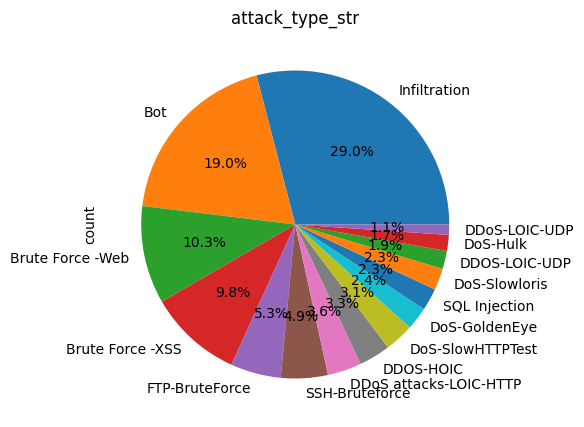

In [6]:
# also plot attack_type with pie chart for attack_types not equal to 0
ATTACK_TYPE_MAPPING_INV = {v: k for k, v in ATTACK_TYPE_MAPPING.items()}
full_data['attack_type_str'] = full_data['attack_type'].map(ATTACK_TYPE_MAPPING_INV)

# remove attack_type 0
data_no_benign = full_data[full_data['attack_type_str'] != 'Benign']

plt.figure(figsize=(5, 5))
data_no_benign['attack_type_str'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('attack_type_str')
plt.show()

## Looking into Entropy

Text(0.5, 1.0, 'count_tcp_flags_urg vs attack_type_str')

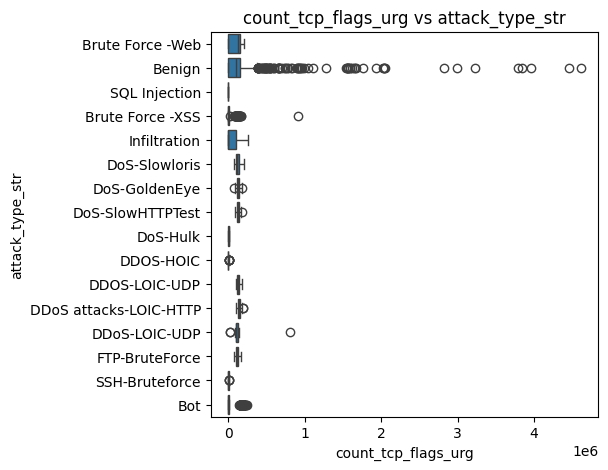

In [22]:
# plot a boxplot for entropy_tcp_time_relative vs attack_type
plt.figure(figsize=(5, 5))
sns.boxplot(data=full_data, y='attack_type_str', x='count_tcp_flags_urg')
plt.title('count_tcp_flags_urg vs attack_type_str')


## Principal Component Analyiss

Correlation matrix:
                      PC1           PC2  Is Attack?
PC1         1.000000e+00  9.367519e-16   -0.006367
PC2         9.367519e-16  1.000000e+00    0.021674
Is Attack? -6.367215e-03  2.167370e-02    1.000000


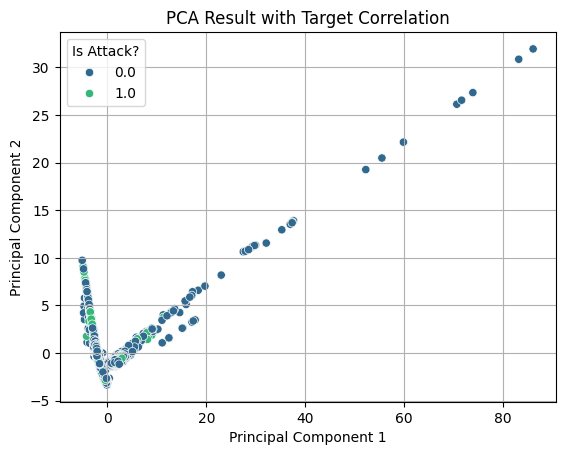


Important features for PC1:
 count_tcp_flags_res          0.977120
count_tcp_flags_cwr          0.977120
count_tcp_flags_ece          0.977120
count_tcp_flags_push         0.977120
count_tcp_flags_reset        0.977120
count_tcp_flags_ae           0.977120
count_tcp_flags_syn          0.977120
count_tcp_flags_urg          0.977120
count_tcp_flags_ack          0.977120
count_tcp_flags_fin          0.977120
entropy_tcp_time_relative    0.682676
entropy_frame_time_delta     0.511961
avg_frame_len                0.455332
stddev_frame_time_delta      0.412450
avg_frame_time_delta         0.395646
entropy_frame_len            0.368483
stddev_frame_len             0.305809
stddev_tcp_time_relative     0.126582
avg_tcp_time_relative        0.090022
Name: PC1, dtype: float64

Important features for PC2:
 avg_frame_time_delta         0.794134
stddev_frame_time_delta      0.790960
entropy_frame_len            0.788978
entropy_frame_time_delta     0.739078
entropy_tcp_time_relative    0.632787
st

In [19]:
# perform PCA on the data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# select only the features we want to use for X input on the RF model
features = [
    'avg_frame_time_delta',
    'avg_frame_len',
    'avg_tcp_time_relative',
    
    'stddev_frame_time_delta',
    'stddev_frame_len',
    'stddev_tcp_time_relative',
    
    'entropy_frame_time_delta',
    'entropy_frame_len',
    'entropy_tcp_time_relative',
    
    'count_tcp_flags_syn',
    'count_tcp_flags_fin',
    'count_tcp_flags_reset',
    'count_tcp_flags_push',
    'count_tcp_flags_ack',
    'count_tcp_flags_urg',
    'count_tcp_flags_ece',
    'count_tcp_flags_cwr',
    'count_tcp_flags_ae',
    'count_tcp_flags_res',
    
    # 'count_proto_tcp',
    # 'count_proto_udp',
    # 'count_proto_tls',
    # 'count_proto_http',
    # 'count_proto_smb',
    # 'count_proto_rdp'
]

X = full_data[features]

# remove NaN values and corresponding rows in full_data['is_attack']
X = X.dropna()
y = full_data.loc[X.index, 'is_attack']

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["Is Attack?"] = y

# get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(loadings, columns=["PC1", "PC2"], index=X.columns)

# correlate PCA components with attack_type
correlation = pca_df.corr()
print("Correlation matrix:\n", correlation)

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Is Attack?", palette="viridis")
plt.title("PCA Result with Target Correlation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

# Identify important features based on loadings
important_features_pc1 = loading_df["PC1"].abs().sort_values(ascending=False)
important_features_pc2 = loading_df["PC2"].abs().sort_values(ascending=False)

print("\nImportant features for PC1:\n", important_features_pc1)
print("\nImportant features for PC2:\n", important_features_pc2)

## Data Distribution

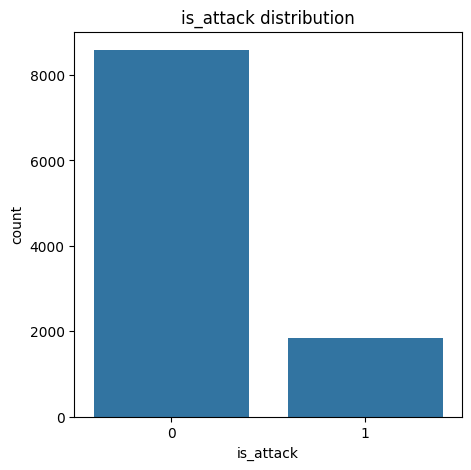

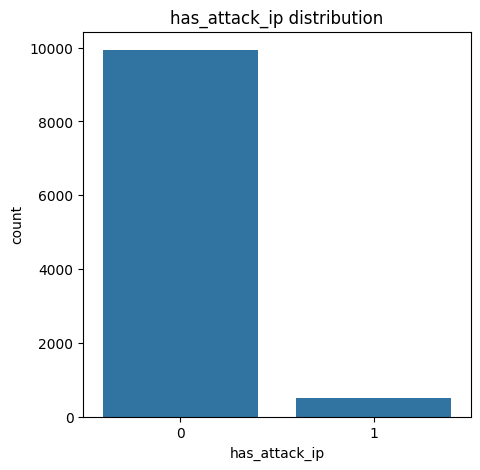

In [ ]:

# analyze distribution of 0 and 1 in is_attack and has_attack_ip
plt.figure(figsize=(5, 5))
sns.countplot(data=full_data, x='is_attack')
plt.title('is_attack distribution')

plt.show()

plt.figure(figsize=(5, 5))
sns.countplot(data=full_data, x='has_attack_ip')
plt.title('has_attack_ip distribution')

plt.show()